Author: Mike Stanley <br>
Written: 8/31/2018

This notebook is written with the intention of reproducing output of parameter learning for GMMs. We will follow the following steps:
1. Learn 2 mixture component GMM with pymc3
2. write my own custom bayesian algorithm to learn what the above learns
3. extend the above to incorporate the dirichlet process prior to learn the number of mixture components

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pymc3 as pm
import theano.tensor as tt

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Generate Data

We generate data for a 2 mixture component GMM.

In [11]:
def gmm_gen_data(p, centers, sds):
    '''
    Generates an observation from a GMM with 2 centers
    '''
    # pick the component it comes from
    mix_comp = stats.bernoulli.rvs(p)
    
    return stats.norm.rvs(loc=centers[mix_comp],
                          scale=sds[mix_comp])

In [12]:
# set p, centers and sds
P = 0.35 # i.e. more likely it is from component 2
CENTERS = [-1, 2]
SDS = [1, 0.5]

In [13]:
# define number of draws
NUM_DRAWS=500

In [14]:
%%time
# generate the data
x_s = []

for i in range(NUM_DRAWS):
    x_s.append(gmm_gen_data(P, CENTERS, SDS))

CPU times: user 45.3 ms, sys: 4.18 ms, total: 49.5 ms
Wall time: 48.6 ms


In [116]:
# make numpy array of the above
x = np.array(x_s)

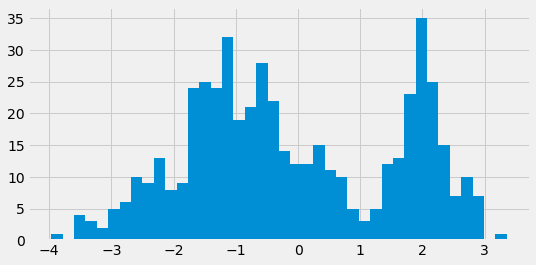

In [44]:
# plot the above
plt.figure(figsize=(8, 4))
plt.hist(x_s, bins=40)
plt.show()

# Learning Using the EM algorithm

##### Functions

In [80]:
def compute_w(x_i, p_0, p_1, centers_hat, sds_hat):
    '''
    computes p(z={0,1}|x_i)
    returns 2 values, one for each mixing component
    '''
    prob_x_giv_0 = stats.norm.pdf(x_i, loc=centers_hat[0], scale=sds_hat[0])
    prob_x_giv_1 = stats.norm.pdf(x_i, loc=centers_hat[1], scale=sds_hat[1])
    
    w_0 = prob_x_giv_0 / (prob_x_giv_0 + prob_x_giv_1)
    w_1 = prob_x_giv_1 / (prob_x_giv_0 + prob_x_giv_1)
    
    return w_0, w_1

def sum_w(W):
    '''
    returns the column sums of the weight matrix
    '''
    N_0, N_1 = W.sum(0)
    return N_0, N_1

def new_p(N_0, N_1, n):
    '''
    computes the new estimates for p_0 and p_1
    '''
    return N_0 / n, N_1 / n

def new_center_sd(x, W, N_0, N_1):
    '''
    the M step. Computing the new gaussian parameter values after
    computing the new mixing weights
    x must be a numpy array
    '''
    # centers
    mu_0 = (1 / N_0) * (W[:,0]*x).sum()
    mu_1 = (1 / N_1) * (W[:,1]*x).sum()
    
    # create vector version of the above
    mu_0_v = np.array([mu_0]*len(x))
    mu_1_v = np.array([mu_1]*len(x))
    
    # sds
    sig2_0 = (1 / N_0) * (W[:,0]*np.square(x-mu_0_v)).sum()
    sig2_1 = (1 / N_1) * (W[:,1]*np.square(x-mu_1_v)).sum()  
    
    return mu_0, mu_1, sig2_0, sig2_1

def log_lik(x, centers, sds, p):
    '''
    computes the log likelihood of data given all the parameters
    '''
    # find p(x|omega)
    p_x = (p[0] * stats.norm.pdf(x, centers[0], sds[0])) + (p[1] * stats.norm.pdf(x, centers[1], sds[1]))
    
    # take the log of the above
    log_p_x = np.log(p_x)
    
    # return the sum of the logs
    return log_p_x.sum()

##### Run EM Algorithm on the simulated data

In [117]:
# algorithm constants

# Max iterations
MAX_ITER = int(1e2)

In [110]:
# make np array version of x_s
x = np.array(x_s)

In [132]:
# create buckets to store parameter values
    # note we're putting in starting values
params = {
    'p_0':[0.5],
    'p_1':[0.5],
    'mu_0':[-1],
    'mu_1':[2],
    'sig2_0':[2],
    'sig2_1':[1]
}

# initialize list to hold log likelihood values
log_lik_val = []

In [133]:
# run the algorithm
for i in range(MAX_ITER):
    # E
    # find the weights
    W = np.zeros((len(x), 2))
    current_centers = np.array([params['mu_0'][-1], params['mu_1'][-1]])
    current_sds = np.array([params['sig2_0'][-1], params['sig2_1'][-1]])

    for idx, x_i in enumerate(x):
        weights = compute_w(x_i, params['p_0'][-1], params['p_1'][-1], 
                            current_centers, current_sds)
        W[idx, 0] = weights[0]
        W[idx, 1] = weights[1]

    # M
    # sum of mixture weights
    N_0_new, N_1_new = sum_w(W) 

    # new ps
    p_0_new, p_1_new = new_p(N_0_new, N_1_new, len(x))

    # new gaussian parameters
    mu_0_new, mu_1_new, sig2_0_new, sig2_1_new = new_center_sd(x, W, N_0_new, N_1_new)

    # add all the new parameters to the dictionary
    params['p_0'].append(p_0_new)
    params['p_1'].append(p_1_new)
    params['mu_0'].append(mu_0_new)
    params['mu_1'].append(mu_1_new)
    params['sig2_0'].append(sig2_0_new)
    params['sig2_1'].append(sig2_1_new)

    # compute log likelihood
    log_lik_val.append(log_lik(x, 
                               centers=[mu_0_new, mu_1_new],
                               sds=[sig2_0_new, sig2_1_new],
                               p=[p_0_new, p_1_new]))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)


In [134]:
params['mu_1']

[2,
 1.6663084045312828,
 1.7546574506070758,
 1.9009221049416407,
 2.0287545171211456,
 2.0442424990001835,
 2.0376167525570423,
 2.024010072342326,
 2.0217137693382377,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

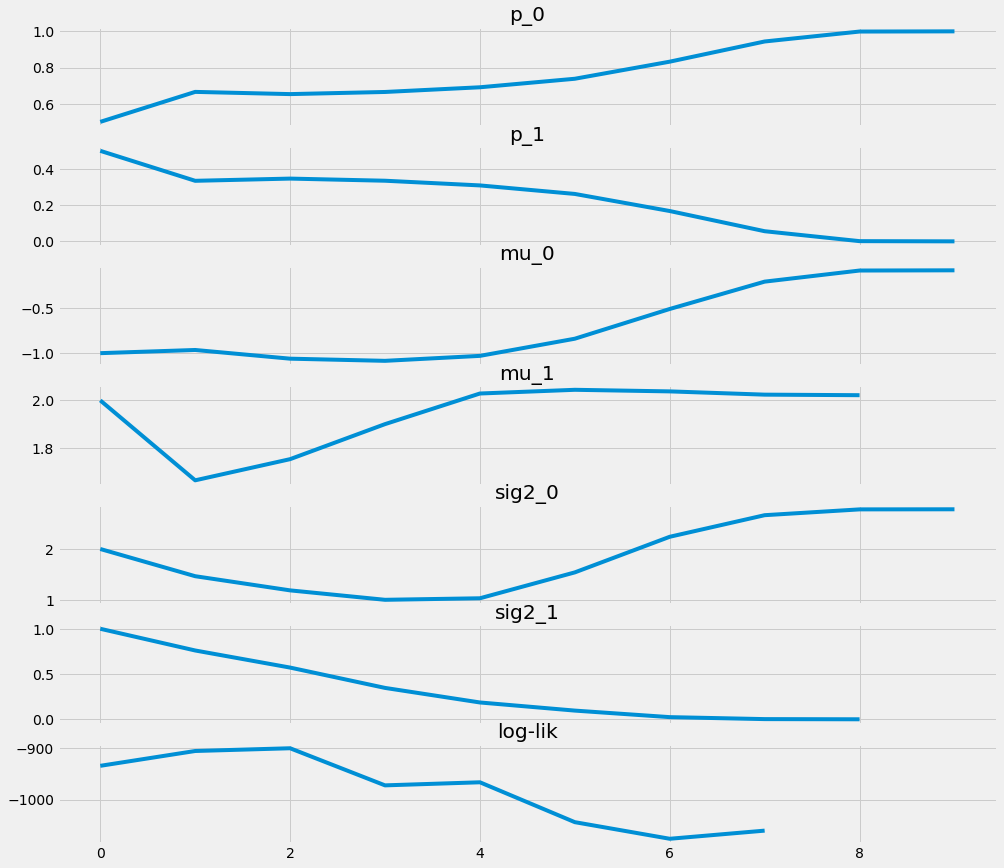

In [135]:
# plot the alg traces

fig, ax = plt.subplots(7, 1, sharex=True, figsize=(15, 14))

# p
ax[0].plot(params['p_0'])
ax[0].set_title('p_0')
ax[1].plot(params['p_1'])
ax[1].set_title('p_1')

# mu
ax[2].plot(params['mu_0'])
ax[2].set_title('mu_0')
ax[3].plot(params['mu_1'])
ax[3].set_title('mu_1')

# sig2
ax[4].plot(params['sig2_0'])
ax[4].set_title('sig2_0')
ax[5].plot(params['sig2_1'])
ax[5].set_title('sig2_1')

# log like
ax[6].plot(log_lik_val)
ax[6].set_title('log-lik')

plt.show()

### Try again...

In [3]:
# constants
MAX_ITER=int(1e4)

In [70]:
# contains to hold the data
param_traces = {
    'p_0':np.zeros(MAX_ITER),
    'p_1':np.zeros(MAX_ITER),
    'mu_0':np.zeros(MAX_ITER),
    'mu_1':np.zeros(MAX_ITER),
    'sig2_0':np.zeros(MAX_ITER),
    'sig2_1':np.zeros(MAX_ITER)
}

log_like_val = []

In [71]:
# generate initial values for parameters
p_0_old = 0.1
p_1_old = 0.9
mu_0_old = -10
mu_1_old = 10
sig2_0_old = 10
sig2_1_old = 1

# EM alg

for i in range(MAX_ITER):
    # specify the cluster distributions given the current parameter values
    clust0 = stats.norm(loc=mu_0_old, scale=sig2_0_old)
    clust1 = stats.norm(loc=mu_1_old, scale=sig2_1_old)

    ### E step
    # compute the weights
    p_x_z0 = clust0.pdf(x) * p_0_old
    p_x_z1 = clust1.pdf(x) * p_1_old
    p_x = p_x_z0 + p_x_z1

    W = np.column_stack((p_x_z0, p_x_z1)) / np.column_stack((p_x, p_x)) # weight matrix w_ij = p(z_i=j|x_i)

    ## M step
    N_0, N_1 = W.sum(0)

    # new estimates for p_0 and p_1
    p_0_new, p_1_new = N_0 / len(x), N_1 / len(x)

    # new estimates for gaussian parameters
    mu_0_new = np.dot(W[:,0], x) / N_0
    mu_1_new = np.dot(W[:,1], x) / N_1

    sig2_0_new = np.dot(W[:, 0], np.square(x - mu_0_new)) / N_0
    sig2_1_new = np.dot(W[:, 1], np.square(x - mu_1_new)) / N_1

    # update the old values
    p_0_old = p_0_new
    p_1_old = p_1_new
    mu_0_old = mu_0_new
    mu_1_old = mu_1_new
    sig2_0_old = sig2_0_new
    sig2_1_old = sig2_1_new

    # add these values to the trace dict
    param_traces['p_0'][i] = p_0_new
    param_traces['p_1'][i] = p_1_new
    param_traces['mu_0'][i] = mu_0_new
    param_traces['mu_1'][i] = mu_1_new
    param_traces['sig2_0'][i] = sig2_0_new
    param_traces['sig2_1'][i] = sig2_1_new

In [72]:
param_traces['mu_0'][:100]

array([0.10645672, 0.10645672, 0.10645672, 0.10645672,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        

In [73]:
param_traces['mu_1'][:100]

array([3.02405844, 3.0086215 , 2.98754481,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        

In [74]:
param_traces['p_0'][:100]

array([ 1.,  1.,  1.,  1., nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [75]:
param_traces['p_1'][:100]

array([1.28560430e-10, 7.72730539e-11, 4.79108412e-42, 0.00000000e+00,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
      

In [76]:
param_traces['sig2_0'][:10]

array([2.69904062, 2.69904062, 2.69904062, 2.69904062,        nan,
              nan,        nan,        nan,        nan,        nan])

In [78]:
param_traces['sig2_1'][:10]

array([3.86043600e-02, 1.73765072e-03, 1.97215226e-31,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan])

##### $p_0$ and $p_1$ estimates for different proposed values of $\mu$

In [89]:
x = np.arange(-5, 5, 0.1)
y = np.arange(-5, 5, 0.1)

xx, yy = np.meshgrid(x, y, sparse=False)

In [92]:
xx

array([[-5. , -4.9, -4.8, ...,  4.7,  4.8,  4.9],
       [-5. , -4.9, -4.8, ...,  4.7,  4.8,  4.9],
       [-5. , -4.9, -4.8, ...,  4.7,  4.8,  4.9],
       ...,
       [-5. , -4.9, -4.8, ...,  4.7,  4.8,  4.9],
       [-5. , -4.9, -4.8, ...,  4.7,  4.8,  4.9],
       [-5. , -4.9, -4.8, ...,  4.7,  4.8,  4.9]])

In [93]:
yy

array([[-5. , -5. , -5. , ..., -5. , -5. , -5. ],
       [-4.9, -4.9, -4.9, ..., -4.9, -4.9, -4.9],
       [-4.8, -4.8, -4.8, ..., -4.8, -4.8, -4.8],
       ...,
       [ 4.7,  4.7,  4.7, ...,  4.7,  4.7,  4.7],
       [ 4.8,  4.8,  4.8, ...,  4.8,  4.8,  4.8],
       [ 4.9,  4.9,  4.9, ...,  4.9,  4.9,  4.9]])

In [84]:
z = np.sin(xx**2 + yy**2) / (xx**2 + yy**22)

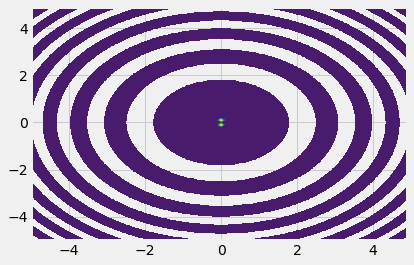

In [85]:
h = plt.contourf(x, y, z)
plt.show()

In [94]:
def p_x_giv_z(mu_0, mu_1, p_0=0.3, p_1=0.7, x_s = x):
    p_z0_x = stats.norm.pdf(x_s, loc=mu_0, scale=1) * p_0
    p_z1_x = stats.norm.pdf(x_s, loc=mu_1, scale=1) * p_1
    
    clust0 = stats.norm(loc=mu_0, scale=1)
    clust1 = stats.norm(loc=mu_1, scale=1)
    
    # compute the weights
    p_x_z0 = clust0.pdf(x_s) * p_0
    p_x_z1 = clust1.pdf(x_s) * p_1
    p_x = p_x_z0 + p_x_z1

    W = np.column_stack((p_x_z0, p_x_z1)) / np.column_stack((p_x, p_x))
    
    return W.sum(0) / len(x_s)

In [104]:
# define values to try for mu_0, and mu_1
mu_0_rng = np.arange(-10, 10, 0.1)
mu_1_rng = np.arange(-10, 10, 0.1)
mu_0_xx, mu_1_yy = np.meshgrid(mu_0_rng, mu_1_rng, sparse=False)

In [106]:
# make an array to store points
probs_p_0 = np.zeros((len(mu_0_rng), len(mu_0_rng)))
probs_p_1 = np.zeros((len(mu_0_rng), len(mu_0_rng)))

In [107]:
for i in range(len(mu_0_rng)):
    for j in range(len(mu_1_rng)):
        probs = p_x_giv_z(mu_0=mu_0_xx[i,j], mu_1=mu_1_yy[i, j])
        probs_p_0[i, j] = probs[0]
        probs_p_1[i, j] = probs[1]

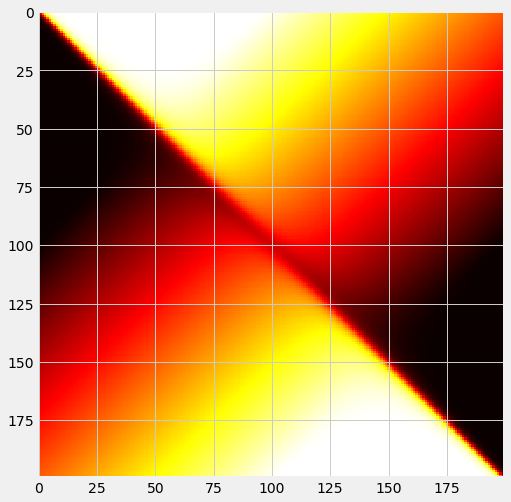

In [109]:
# plot a heat maps for p_0
plt.figure(figsize=(8, 8))
plt.imshow(probs_p_0, cmap='hot')
plt.show()

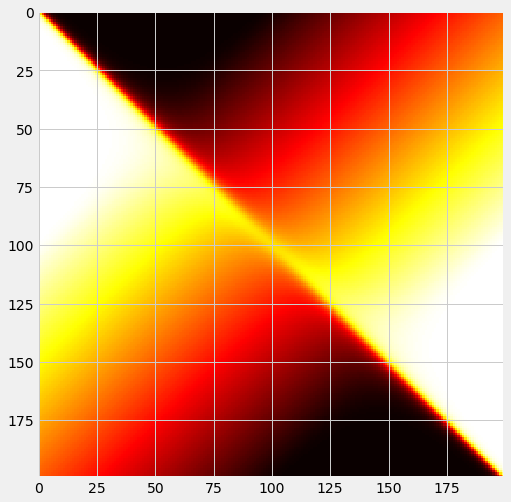

In [110]:
# plot a heat maps for p_1
plt.figure(figsize=(8, 8))
plt.imshow(probs_p_1, cmap='hot')
plt.show()

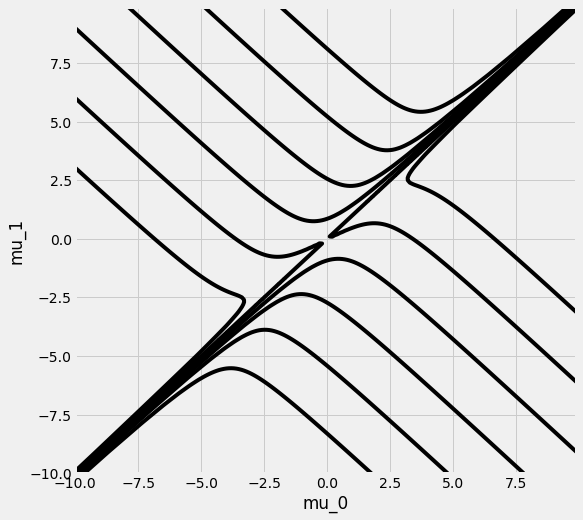

In [112]:
# contour map
plt.figure(figsize=(8, 8))
plt.contour(mu_0_rng, mu_1_rng, probs_p_0, colors='k')

plt.xlabel('mu_0')
plt.ylabel('mu_1')
plt.show()

# Using pymc3

Using this link: https://docs.pymc.io/notebooks/gaussian_mixture_model.html

In [115]:
x.shape, NUM_DRAWS

((100,), 500)

In [119]:
# setup model
with pm.Model() as model:
    # cluster sizes
    p = pm.Dirichlet('p', a=np.array([1., 1.]), shape=2)
    
    # ensure all clusters have some points
    p_min_potential = pm.Potential('p_min_potential', tt.switch(tt.min(p) < 0.1, -np.inf, 0))
    
    # cluster centers
    means = pm.Normal('means', mu = [0., 0.], sd=15, shape=2)
    # break symmetry
    order_means_potential = pm.Potential('order_means_potential',
                                         tt.switch(means[1]-means[0] < 0, -np.inf, 0))
    
    # measurement error
    sd = pm.Uniform('sd', lower=0, upper=20)
    
    # latent cluster of each observation
    category = pm.Categorical('category', p=p, shape=NUM_DRAWS)
    
    # likelihood of each observed cluster
    points = pm.Normal('obs', mu=means[category], sd=sd, observed=x)

In [120]:
# fit the model
with model:
    step1=pm.Metropolis(vars=[p, sd, means])
    step2=pm.ElemwiseCategorical(vars=[category], values=[0,1])
    tr = pm.sample(10000, step=[step1, step2])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  after removing the cwd from sys.path.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [means]
>>Metropolis: [sd]
>>Metropolis: [p]
>ElemwiseCategorical: [category]
Sampling 2 chains: 100%|██████████| 21000/21000 [01:38<00:00, 213.26draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


### Full Trace

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2166a828>,
      dtype=object)

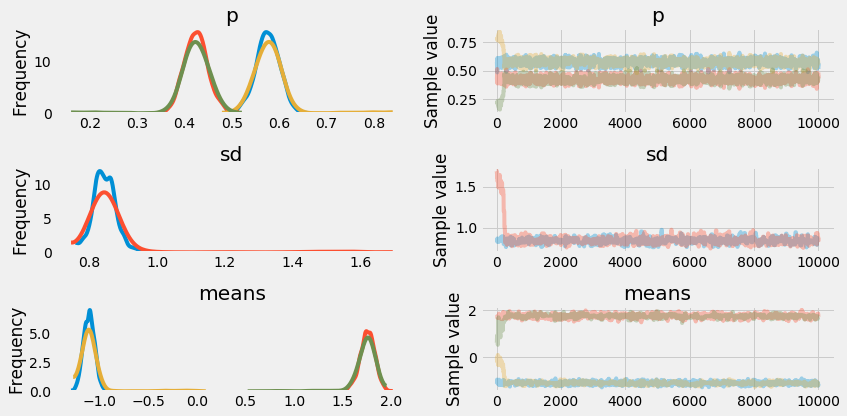

In [121]:
pm.plots.traceplot(tr, ['p', 'sd', 'means'])

### After Convergence

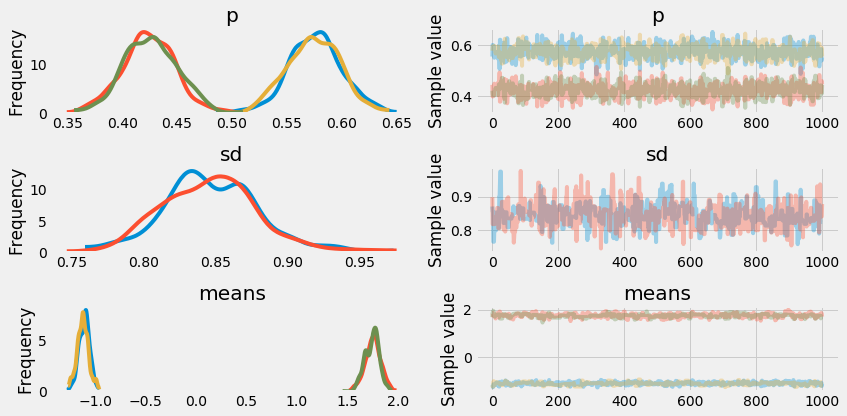

In [122]:
# look at the traces with some burn-in and thinning
pm.plots.traceplot(tr[5000::5], ['p', 'sd', 'means'])
plt.show()

### Sampling of Cluster for individual data point

In [147]:
tr['sd_interval__']

array([-3.11063403, -3.11063403, -3.11063403, ..., -3.08114914,
       -3.14041645, -3.14041645])

(-149.95000000000002, 3148.95, -0.1, 2.1)

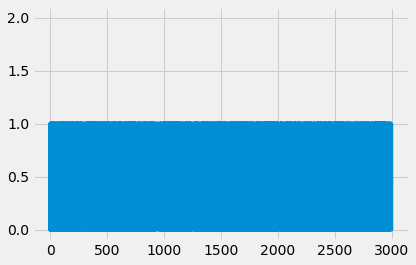

In [127]:
i = 0
plt.plot(tr['category'][5000::5,i], drawstyle='steps-mid')
plt.axis(ymin=-0.1, ymax=2.1)

In [140]:
def cluster_posterior(i=0):
    print('data value: %.2f' % x[i])
    plt.hist(tr['category'][5000::5, i], bins=[-0.35, .35, 0.65, 1.35], density=True)
    plt.xticks([0, 1])
    plt.show()

data value: -1.14


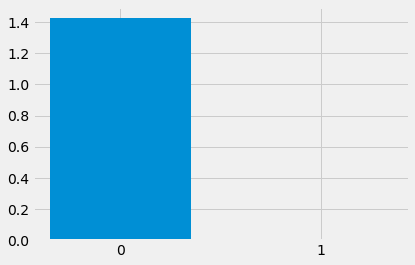

In [141]:
cluster_posterior(10)

# Austin Rochford's Post

##### Sampling from a dirichlet process using the stick breaking process

In [2]:
from __future__ import division
import scipy as sp
import seaborn as sns
from statsmodels.datasets import get_rdataset
from theano import tensor as T

In [3]:
blue = sns.color_palette()[0]

In [4]:
# set a random seed
np.random.seed(462233)

In [5]:
# constants
N = 20
K = 30

alpha = 2.
P0 = stats.norm

In [17]:
# define x_plot for later
x_plot = np.linspace(-3, 3, 200)

In [6]:
# draw samples from the stick breaking process
beta = stats.beta.rvs(1, alpha, size = (N, K))
w = np.empty_like(beta)
w[:, 0] = beta[:, 0] # fill in the weight value
w[:, 1:] = beta[:, 1:] * (1 - beta[:, :-1]).cumprod(axis=1)

omega = P0.rvs(size=(N, K)) # samples from the base distribution

x_plot = np.linspace(-3, 3, 200)

sample_cdfs = (w[..., np.newaxis] * np.less.outer(omega, x_plot)).sum(axis=1)

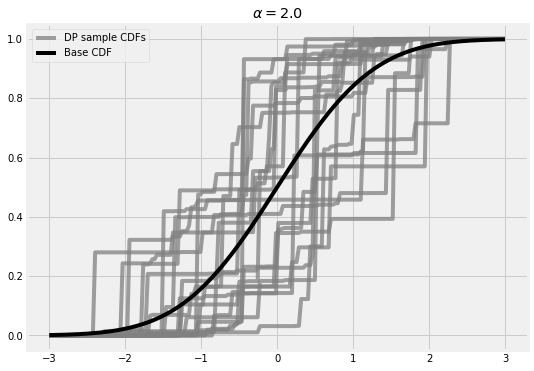

In [7]:
# plot the above 
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x_plot, sample_cdfs[0], c='gray', alpha=0.75,
        label='DP sample CDFs');
ax.plot(x_plot, sample_cdfs[1:].T, c='gray', alpha=0.75);
ax.plot(x_plot, P0.cdf(x_plot), c='k', label='Base CDF');

ax.set_title(r'$\alpha = {}$'.format(alpha));
ax.legend(loc=2)
plt.show()

As $\alpha$ approaches infinity, the dirichlet process converges to the base distribution

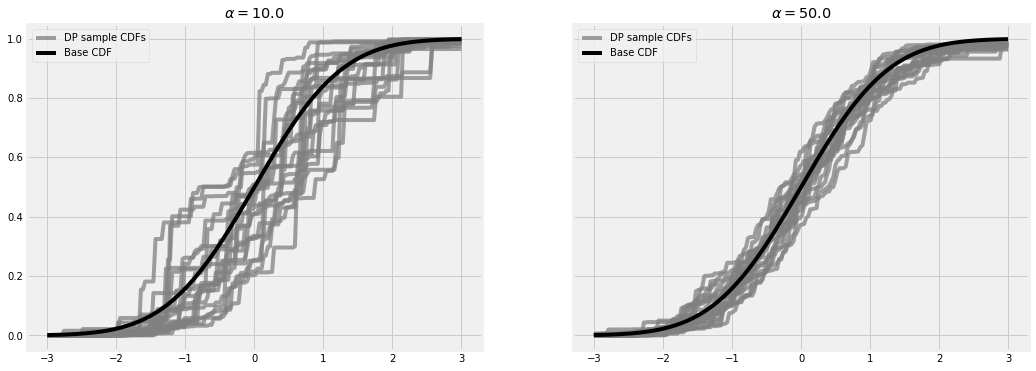

In [8]:
fig, (l_ax, r_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(16, 6))

# alpha = 10
K = 50

alpha = 10.
P0 = stats.norm

beta = stats.beta.rvs(1, alpha, size = (N, K))
w = np.empty_like(beta)
w[:, 0] = beta[:, 0] # fill in the weight value
w[:, 1:] = beta[:, 1:] * (1 - beta[:, :-1]).cumprod(axis=1)

omega = P0.rvs(size=(N, K)) # samples from the base distribution

sample_cdfs = (w[..., np.newaxis] * np.less.outer(omega, x_plot)).sum(axis=1)

l_ax.plot(x_plot, sample_cdfs[0], c='gray', alpha=0.75,
          label='DP sample CDFs');
l_ax.plot(x_plot, sample_cdfs[1:].T, c='gray', alpha=0.75);
l_ax.plot(x_plot, P0.cdf(x_plot), c='k', label='Base CDF');

l_ax.set_title(r'$\alpha = {}$'.format(alpha));
l_ax.legend(loc=2)

# alpha = 50
K = 200
alpha = 50.
P0 = stats.norm

beta = stats.beta.rvs(1, alpha, size = (N, K))
w = np.empty_like(beta)
w[:, 0] = beta[:, 0] # fill in the weight value
w[:, 1:] = beta[:, 1:] * (1 - beta[:, :-1]).cumprod(axis=1)

omega = P0.rvs(size=(N, K)) # samples from the base distribution

sample_cdfs = (w[..., np.newaxis] * np.less.outer(omega, x_plot)).sum(axis=1)

r_ax.plot(x_plot, sample_cdfs[0], c='gray', alpha=0.75,
          label='DP sample CDFs');
r_ax.plot(x_plot, sample_cdfs[1:].T, c='gray', alpha=0.75);
r_ax.plot(x_plot, P0.cdf(x_plot), c='k', label='Base CDF');

r_ax.set_title(r'$\alpha = {}$'.format(alpha));
r_ax.legend(loc=2)

plt.show()

In [9]:
w[...,np.newaxis].shape

(20, 200, 1)

In [10]:
(w[..., np.newaxis] * np.less.outer(omega, x_plot)).shape

(20, 200, 200)

This guy above is tricky. `np.less.outer(omega, x_plot)` its basically saying, for every element in the omega matrix, create an additional dimention of true/false saying if $\omega_ij < x$. The, `w[...,np.newaxis]` just adds a dimension in terms of the first coordinate of the array. Here, the `np.less.outer(omega, x_plot)` bit of code is acting as the $\delta_{\omega}$ where the fact that we're looking for the cdf is enforced by how $S \subset \Omega$ is defined. Here, since $\delta_{\omega} = 1$ when $\omega \in S$, we define $S = [x, +)$

In [11]:
# look how the shape is expanded
(w[..., np.newaxis] * np.less.outer(omega, x_plot)).shape

(20, 200, 200)

In [12]:
# look at what's equal here
np.equal(w[..., np.newaxis][0, :, 0], w[0, :]).sum()

200

#### Dirichlet Process Mixtures

We use a mixture model for which our mixture weights are samples from a dirichlet process, where <br>
$x_i \vert \theta_i \sim f_{\theta_i}$ <br>
$\theta_1, \dots, \theta_n \sim P$ <br>
$P \sim DP(\alpha, P_0)$

Simulating draws from a dirichlet process mixture...

In [13]:
N = 5
K = 30

alpha = 2.
P0 = stats.norm
f = lambda x, theta: stats.norm.pdf(x, theta, 0.3)

In [14]:
# stick breaking
beta = stats.beta.rvs(1, alpha, size=(N,K))
w = np.empty_like(beta)
w[:,0] = beta[:,0]
w[:,1:] = beta[:,1:] * (1 - beta[:, :-1]).cumprod(axis=1)

theta = P0.rvs(size=(N,K))

dpm_pdf_components = f(x_plot[np.newaxis, np.newaxis, :], theta[..., np.newaxis])
dpm_pdfs = (w[..., np.newaxis] * dpm_pdf_components).sum(axis=1)

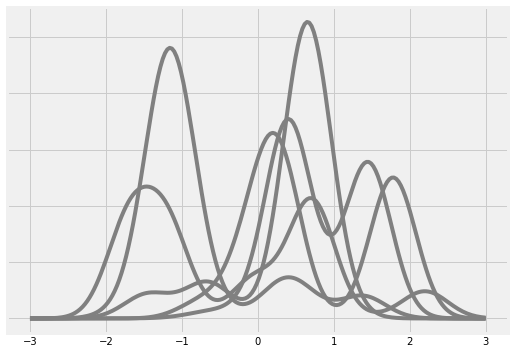

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x_plot, dpm_pdfs.T, c='gray');

ax.set_yticklabels([])
plt.show()

In [16]:
dpm_pdf_components.shape

(5, 30, 200)

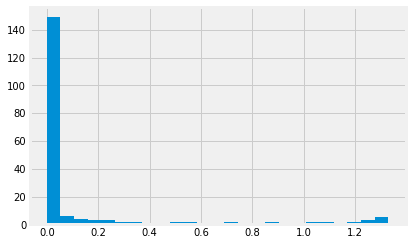

In [17]:
plt.hist(dpm_pdf_components[0,0, :], bins=25)
plt.show()

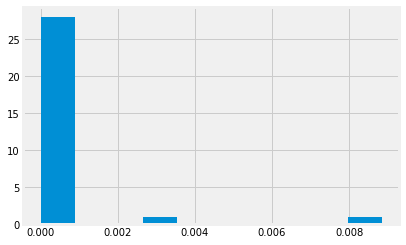

In [18]:
plt.hist(dpm_pdf_components[0,:, 0])
plt.show()

Focus on a single mixture and decompose it into its individual components

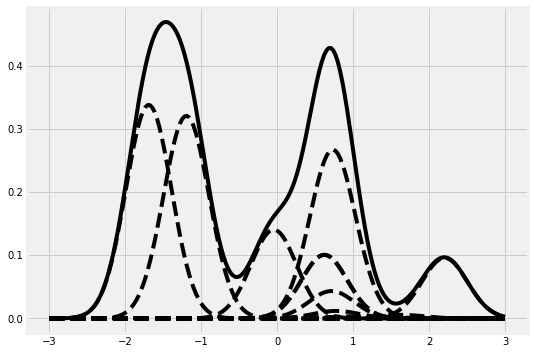

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))

ix = 1

ax.plot(x_plot, dpm_pdfs[ix], c='k', label='Density')

ax.plot(x_plot, (w[..., np.newaxis] * dpm_pdf_components)[ix, 0],
        '--', c='k', label='Mixture components (weighted)')

ax.plot(x_plot, (w[..., np.newaxis] * dpm_pdf_components)[ix].T,
        '--', c='k');

plt.show()

In [20]:
(w[..., np.newaxis] * dpm_pdf_components)[ix].T.shape

(200, 30)

#### Estimating waiting times between eruptions of Old Faithful

In [6]:
# get the data
old_faithful_df = get_rdataset('faithful', cache=True).data[['waiting']]

In [7]:
# standardizing the wait time between eruptions
old_faithful_df['std_waiting'] = (old_faithful_df.waiting - old_faithful_df.waiting.mean()) / old_faithful_df.waiting.std()

In [8]:
old_faithful_df.head()

,waiting,std_waiting
0,79,0.596025
1,54,-1.242890
2,74,0.228242
3,62,-0.654437
4,85,1.037364


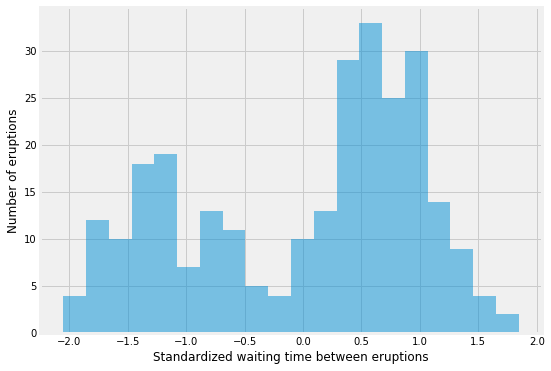

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))

n_bins = 20
ax.hist(old_faithful_df.std_waiting, bins=n_bins, color=blue, lw=0, alpha=0.5);

ax.set_xlabel('Standardized waiting time between eruptions');
ax.set_ylabel('Number of eruptions')
plt.show()

Here is the hierarchical model we use:<br>
$x_i \vert \mu_i, \lambda_i, \tau_i \sim N(\mu, (\lambda_i \tau_i)^{-1})$ <br>
$\mu_i \vert \lambda_i, \tau_i \sim N(0, (\lambda_i \tau_i)^{-1})$ <br>
$(\lambda_1, \tau_1), (\lambda_1, \tau_2), ... \sim P$ <br>
$P \sim DP(\alpha, U(0, 5) * Gamma(1, 1))$ <br>
$\alpha \sim Gamma(1, 1)$

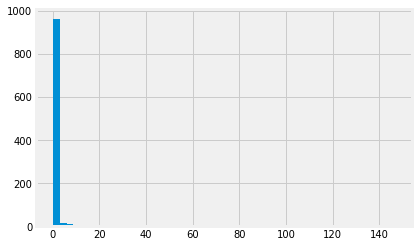

In [66]:
# check out the gamma distribution
gamma_samples = stats.gamma.rvs(1, 1, size=1000)
uniform_samples = stats.uniform.rvs(0, 5, size=1000)

plt.hist(np.power(gamma_samples*uniform_samples, -1), bins=50)
plt.show()

In [10]:
N = old_faithful_df.shape[0]

K = 30

In [11]:
with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1., alpha, shape=K)
    w = pm.Deterministic('w', beta * T.concatenate([[1], T.extra_ops.cumprod(1 - beta)[:-1]]))
    component = pm.Categorical('component', w, shape=N)

    sd = pm.InverseGamma('inv_gamma', 1., 1., shape=K)
    #lambda_ = pm.Uniform('lambda', 0., 5., shape=K)
    mu = pm.Normal('mu', 0, sd, shape=K)
    obs = pm.Normal('obs', mu[component], sd[component],
                    observed=old_faithful_df.std_waiting.values)

In [12]:
# sample the posterior 20k times, burn first 10k and thin with every 10th sample
with model:
    step1 = pm.Metropolis(vars=[alpha, beta, w, sd, mu, obs])
    step2 = pm.ElemwiseCategorical([component], np.arange(K))
    
    trace_ = pm.sample(20000, [step1, step2])

trace = trace_[10000::10]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  after removing the cwd from sys.path.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [mu]
>>Metropolis: [inv_gamma]
>>Metropolis: [beta]
>>Metropolis: [alpha]
>ElemwiseCategorical: [component]
Sampling 2 chains: 100%|██████████| 41000/41000 [03:10<00:00, 214.92draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


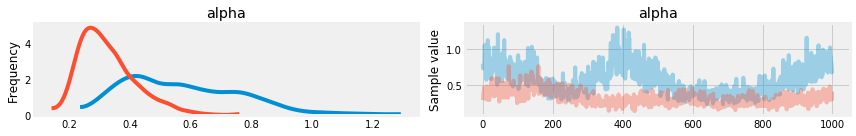

In [13]:
# plot the posterior for alpha
pm.traceplot(trace, varnames=['alpha'])
plt.show()

To verify that we have biased our results with picking of truncation point, plot the distribution for the number of mixtures used.

In [14]:
# find the number of components used
n_components_used = np.apply_along_axis(lambda x: np.unique(x).size, 1, trace['component'])

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


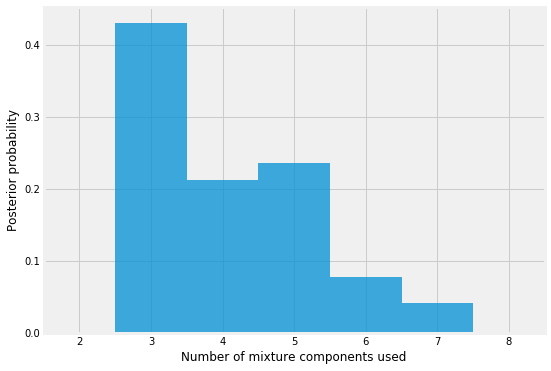

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))

bins = np.arange(n_components_used.min(), n_components_used.max() + 1)
ax.hist(n_components_used + 1, bins=bins, normed=True, lw=0, alpha=0.75);

ax.set_xticks(bins + 0.5);
ax.set_xticklabels(bins);
ax.set_xlim(bins.min(), bins.max() + 1);
ax.set_xlabel('Number of mixture components used');

ax.set_ylabel('Posterior probability');

In [18]:
# compute our posterior estimates`
post_pdf_contribs = stats.norm.pdf(np.atleast_3d(x_plot),
                                   trace['mu'][:, np.newaxis, :],
#                                   1. / np.sqrt(trace['lambda'] * trace['tau'])[:, np.newaxis,:])
                                   trace['inv_gamma'][:, np.newaxis, :])

post_pdfs = (trace['w'][:, np.newaxis,:] * post_pdf_contribs).sum(axis=-1)

post_pdf_low, post_pdf_high = np.percentile(post_pdfs, [2.5, 97.5], axis=0)

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


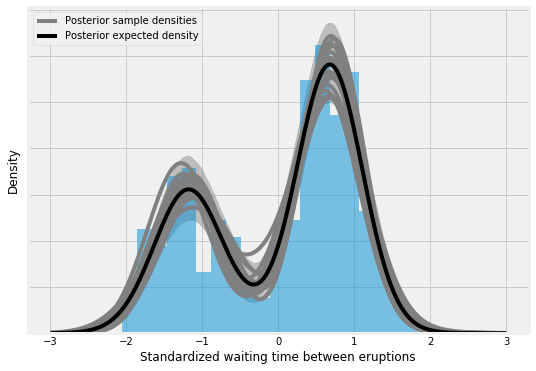

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))

n_bins = 20
ax.hist(old_faithful_df.std_waiting.values, bins=n_bins, normed=True,
        color=blue, lw=0, alpha=0.5);

ax.fill_between(x_plot, post_pdf_low, post_pdf_high,
                color='gray', alpha=0.45);
ax.plot(x_plot, post_pdfs[0],
        c='gray', label='Posterior sample densities');
ax.plot(x_plot, post_pdfs[::100].T, c='gray');
ax.plot(x_plot, post_pdfs.mean(axis=0),
        c='k', label='Posterior expected density');

ax.set_xlabel('Standardized waiting time between eruptions');

ax.set_yticklabels([]);
ax.set_ylabel('Density');

ax.legend(loc=2);
plt.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


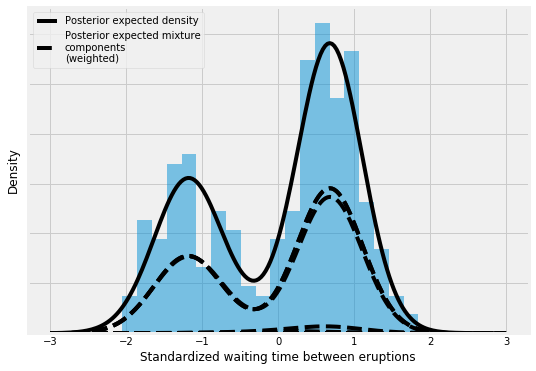

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))

n_bins = 20
ax.hist(old_faithful_df.std_waiting.values, bins=n_bins, normed=True,
        color=blue, lw=0, alpha=0.5);

ax.plot(x_plot, post_pdfs.mean(axis=0),
        c='k', label='Posterior expected density');
ax.plot(x_plot, (trace['w'][:, np.newaxis, :] * post_pdf_contribs).mean(axis=0)[:, 0],
        '--', c='k', label='Posterior expected mixture\ncomponents\n(weighted)');
ax.plot(x_plot, (trace['w'][:, np.newaxis, :] * post_pdf_contribs).mean(axis=0),
        '--', c='k');

ax.set_xlabel('Standardized waiting time between eruptions');

ax.set_yticklabels([]);
ax.set_ylabel('Density');

ax.legend(loc=2);

##### Estimating Subspot density

In [21]:
# get the data
sunspot_df = get_rdataset('sunspot.year', cache=True).data

In [22]:
sunspot_df.head()

,time,value
0,1700,5.0
1,1701,11.0
2,1702,16.0
3,1703,23.0
4,1704,36.0


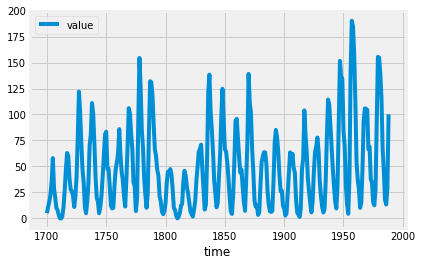

In [23]:
sunspot_df.plot(x='time', y='value')
plt.show()

The problem is to estimate the density of sunspots per year

In [24]:
N = sunspot_df.shape[0] # number of data points
K = 30                  # max number of components

In [25]:
with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1, alpha, shape=K)
    w = pm.Deterministic('w', beta * T.concatenate([[1], T.extra_ops.cumprod(1 - beta)[:-1]]))
    component = pm.Categorical('component', w, shape=N)
    
    mu = pm.Uniform('mu', 0., 300., shape=K)
    obs = pm.Poisson('obs', mu[component], observed=sunspot_df['value'])

In [26]:
with model:
    step1 = pm.Metropolis(vars=[alpha, beta, w, mu, obs])
    step2 = pm.ElemwiseCategorical([component], np.arange(K))
    
    trace_ = pm.sample(20000, [step1, step2])
    
trace = trace_[10000::10]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  This is separate from the ipykernel package so we can avoid doing imports until
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [mu]
>>Metropolis: [beta]
>>Metropolis: [alpha]
>ElemwiseCategorical: [component]
Sampling 2 chains: 100%|██████████| 41000/41000 [02:49<00:00, 241.63draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


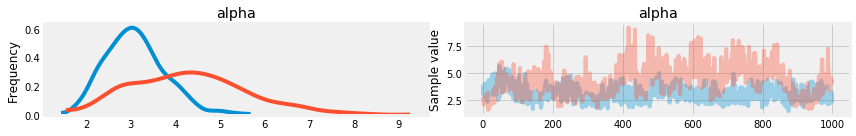

In [27]:
pm.traceplot(trace, varnames=['alpha']);
plt.show()

In [28]:
# find the posterior for the number of components used
n_components_used = np.apply_along_axis(lambda x: np.unique(x).size, 1, trace['component'])

In [29]:
trace['component'][-100:, 0]

array([11, 11, 11, 11, 11, 11,  7, 11, 11,  7,  7, 11, 11, 11, 11, 11, 11,
       11, 11,  7, 11, 11,  7, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11,  7, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,  7, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,  7,
       11, 11, 11, 11, 11, 11,  3, 11, 11, 11,  7,  7, 11, 11, 11])

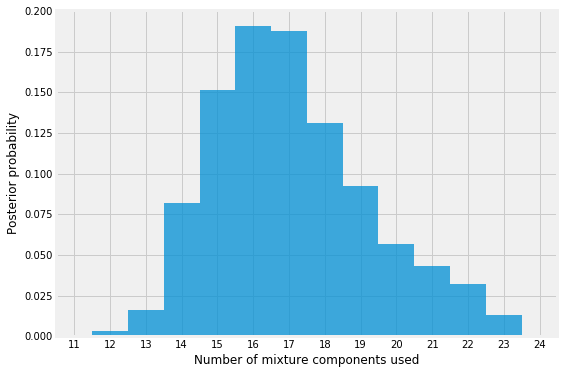

In [30]:
fig, ax = plt.subplots(figsize=(8, 6))

bins = np.arange(n_components_used.min(), n_components_used.max() + 1)
ax.hist(n_components_used + 1, bins=bins, density=True, lw=0, alpha=0.75);

ax.set_xticks(bins + 0.5);
ax.set_xticklabels(bins);
ax.set_xlim(bins.min(), bins.max() + 1);
ax.set_xlabel('Number of mixture components used');

ax.set_ylabel('Posterior probability');
plt.show()

In [31]:
# get the x values to plot the computed densities
x_plot = np.arange(250)

In [32]:
post_pmf_contribs = stats.poisson.pmf(np.atleast_3d(x_plot), 
                                      trace['mu'][:, np.newaxis, :])

post_pmf = (trace['w'][:, np.newaxis, :] * post_pmf_contribs).sum(axis=-1)

post_pmf_low, post_pmf_high = np.percentile(post_pmf, [2.5, 97.5], axis=0)

In [33]:
(trace['w'][:, np.newaxis, :] * post_pmf_contribs).shape

(2000, 250, 30)

In [34]:
(trace['w'][:, np.newaxis, :] * post_pmf_contribs).sum(axis=-1).shape

(2000, 250)

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


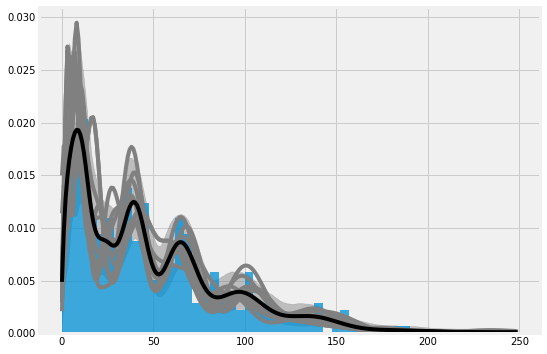

In [35]:
fig, ax = plt.subplots(figsize=(8,6))

# plot the observed distribution
plt.hist(sunspot_df['value'].values, bins=40, normed=True, lw=0, alpha=0.75)

# fill in the 95% credible interval
ax.fill_between(x_plot, post_pmf_low, post_pmf_high,
                color='gray', alpha=0.45)

ax.plot(x_plot, post_pmf[0],
        c='gray', label='Posterior sample densities');
ax.plot(x_plot, post_pmf[::200].T, c='gray');

ax.plot(x_plot, post_pmf.mean(axis=0),
        c='k', label='Posterior expected density');

plt.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


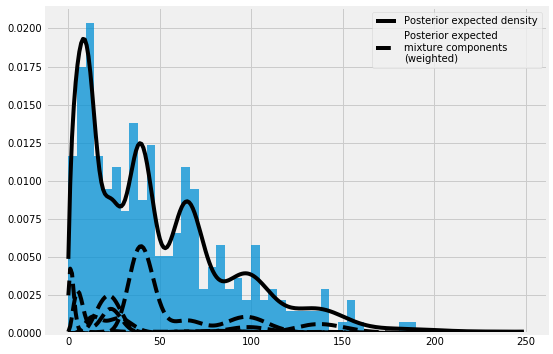

In [36]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(sunspot_df['value'].values, bins=40, normed=True, lw=0, alpha=0.75);
ax.plot(x_plot, post_pmf.mean(axis=0),
        c='k', label='Posterior expected density');
ax.plot(x_plot, (trace['w'][:, np.newaxis, :] * post_pmf_contribs).mean(axis=0)[:, 0], # all x values, component 1
        '--', c='k', label='Posterior expected\nmixture components\n(weighted)');
ax.plot(x_plot, (trace['w'][:, np.newaxis, :] * post_pmf_contribs).mean(axis=0)[:,10:20],
        '--', c='k');

ax.legend(loc=1);

plt.show()

In [37]:
(trace['beta'][:, np.newaxis, :] * post_pmf_contribs).shape

(2000, 250, 30)

##### Do weights tell us the 'importance'?

In [38]:
comp_weight_sort = [i[1] for i in sorted(zip(trace['w'].mean(axis=0), range(30)), 
                                         key=lambda tup: tup[0], reverse=True)]

In [39]:
np.sort(trace['w'].mean(axis=0))

array([0.00033046, 0.00036375, 0.00060983, 0.00074209, 0.00075887,
       0.00082896, 0.00096166, 0.0020025 , 0.00224803, 0.00233027,
       0.00354987, 0.00555319, 0.00831991, 0.00903667, 0.01020134,
       0.01573303, 0.02187135, 0.02263134, 0.02530299, 0.02713477,
       0.0346311 , 0.04231908, 0.05599832, 0.07597944, 0.07613461,
       0.09580106, 0.0998172 , 0.10301531, 0.10851123, 0.14492718])

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


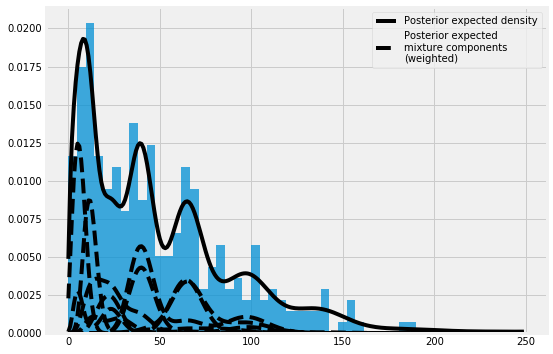

In [40]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(sunspot_df['value'].values, bins=40, normed=True, lw=0, alpha=0.75);
ax.plot(x_plot, post_pmf.mean(axis=0),
        c='k', label='Posterior expected density');
ax.plot(x_plot, (trace['w'][:, np.newaxis, :] * post_pmf_contribs).mean(axis=0)[:, comp_weight_sort[0]], 
        '--', c='k', label='Posterior expected\nmixture components\n(weighted)');

ax.plot(x_plot, (trace['w'][:, np.newaxis, :] * post_pmf_contribs).mean(axis=0)[:, comp_weight_sort[1:10]], 
        '--', c='k');

ax.legend(loc=1);

plt.show()